In [1]:
import os
import time
from tqdm import tqdm

from collections import Counter

from scipy.stats import mode

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import pandas as pd

import zipfile

import torch
import torchaudio
import torchaudio.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset

import librosa
import librosa.display
from IPython.display import Audio

#### Loading example data with Torch-audio / Creating test-spectograms

In [5]:
def plot_waveform(waveform, sample_rate, title = "Waveform"):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time = np.arange(0, num_frames) / sample_rate

    fig, axes = plt.subplots(num_channels, 1)

    if num_channels == 1:
        axes = [axes]
    for ch in range(num_channels):
        axes[ch].plot(time, waveform[ch])
        axes[ch].grid(True)

        if num_channels > 1:
            axes[ch].set_ylabel(f"Channel: {ch+1}")
        plt.suptitle(title)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude(16-bit)')
        plt.show(block = False)
        
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
def show_song_information(path, title='Waveform'):
    waveform, sample_rate = torchaudio.load(path)

    song_data, _ = librosa.load(path,sr=sample_rate)

    plot_waveform(waveform, sample_rate, title=title)
    spec = create_spectogram(waveform, sample_rate, plot_spectogram=False)
    plot_spectrogram(spec[0], title=title + ' (db)')
    print(torchaudio.info(path))
    print(f"Shape of the waveform: {waveform.size()}")
    print(f"Sampling rate of the audio file: {sample_rate}")
    display(Audio(song_data,rate=sample_rate))
    
def create_spectogram(waveform, sample_rate, n_fft=1024, hop_length=512, n_mels=128, plot_spectogram=False, norm='slaney', mel_scale='htk'):
    n_fft = n_fft # size of the fast Fourier transform
    hop_length = hop_length # length of the hop between short-time Fourier transform windows
    n_mels = n_mels 
    norm = norm
    mel_scale = mel_scale

    spectrogram = transforms.MelSpectrogram(sample_rate=sample_rate,
                                            n_fft=n_fft,
                                            hop_length=hop_length,
                                            center=True,
                                            pad_mode="reflect",
                                            power=2.0,
                                            norm=norm,
                                            n_mels=n_mels,
                                            mel_scale=mel_scale
                                        )
    spec = spectrogram(waveform)
    
    if plot_spectogram:
        plot_spectogram(spec)
    return spec

def trim_tensor_spectograms(spectograms):
    max_time_steps = min(spec.shape[2] for spec in spectograms) # used to be 1293

    # Post-process spectrograms to have a fixed number of time steps
    processed_spectograms = []
    for spectrogram in spectograms:
        if spectrogram.shape[2] < max_time_steps:
            # Pad the spectrogram if it has fewer time steps
            padding = max_time_steps - spectrogram.shape[2]
            spectrogram = torch.nn.functional.pad(spectrogram, (0, padding))
        elif spectrogram.shape[2] > max_time_steps:
            # Trim the spectrogram if it has more time steps
            spectrogram = spectrogram[:, :, :max_time_steps]

        processed_spectograms.append(spectrogram)

    processed_spectograms = torch.stack(processed_spectograms)
    return processed_spectograms

def tensors_to_img(spectograms):
    imgs = []
    for spectogram in spectograms:
        imgs.append(librosa.power_to_db(spectogram))        
    return imgs

def normalize_img_spectograms(spectograms):
    normalized_spectograms = []

    for spectrogram in spectograms:
        # Normalize each spectrogram by dividing by the maximum absolute value
        max_abs = np.max(np.abs(spectrogram))
        normalized_spectogram = spectrogram / max_abs
        normalized_spectograms.append(normalized_spectogram)

    normalized_spectograms = np.array(normalized_spectograms)
    normalized_spectograms = (normalized_spectograms + 1) / 2
    return normalized_spectograms

def log_scale_spectogram(spectograms):
    logged_specs = []
    
    for spectogram in spectograms:
        # Add a small constant to avoid log(0)
        log_spectogram = np.log1p(spectogram + 1e-9)
        logged_specs.append(log_spectogram)
    return logged_specs

def convert_imgs_to_grayscale(images):
    gray_images = []
    for image in images:
        gray_image = np.mean(image, axis=-1, keepdims=True)
        gray_images.append(np.array(gray_image))
    return gray_images

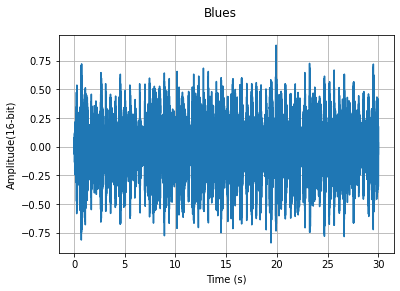

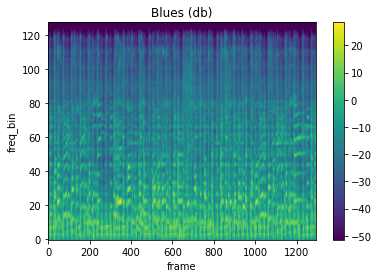

AudioMetaData(sample_rate=22050, num_frames=661794, num_channels=1, bits_per_sample=16, encoding=PCM_S)
Shape of the waveform: torch.Size([1, 661794])
Sampling rate of the audio file: 22050


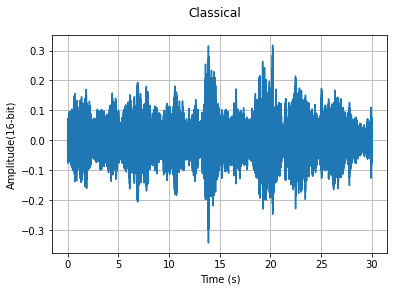

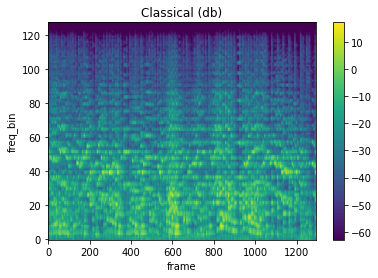

AudioMetaData(sample_rate=22050, num_frames=661794, num_channels=1, bits_per_sample=16, encoding=PCM_S)
Shape of the waveform: torch.Size([1, 661794])
Sampling rate of the audio file: 22050


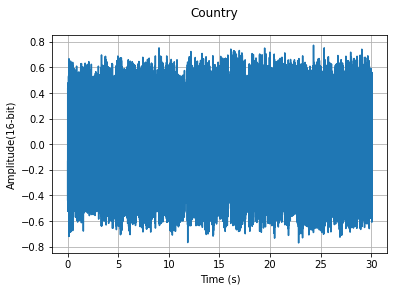

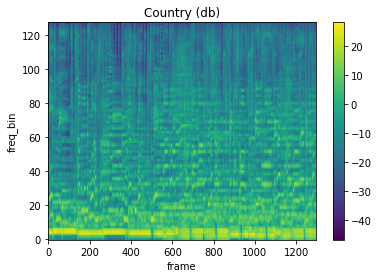

AudioMetaData(sample_rate=22050, num_frames=663300, num_channels=1, bits_per_sample=16, encoding=PCM_S)
Shape of the waveform: torch.Size([1, 663300])
Sampling rate of the audio file: 22050


In [6]:
# inspiration from https://www.scaler.com/topics/pytorch/torchaudio-in-pytorch/

sample_blues = './genre_data/Data/genres_original/blues/blues.00000.wav'
sample_classical = './genre_data/Data/genres_original/classical/classical.00000.wav'
sample_country = './genre_data/Data/genres_original/country/country.00000.wav'
    
show_song_information(sample_blues, title='Blues')
show_song_information(sample_classical, title='Classical')
show_song_information(sample_country, title='Country')

#### Loading data + file-paths and storing them in a dataframe

In [7]:
root_dir = './genre_data/Data/genres_original/'

genres = []
file_paths = []

dirs = os.listdir(root_dir)
for item in dirs:
    temp_dirpath = root_dir + item + '/'
    
    files = os.listdir(temp_dirpath)
    for file in files:
        genres.append(item)
        file_paths.append(temp_dirpath + file)

data = {'Genre': genres, 'Song_paths': file_paths}
genres_and_files = pd.DataFrame(data)
genres_and_files

Genre                                         Song_paths
0    disco  ./genre_data/Data/genres_original/disco/disco....
1    disco  ./genre_data/Data/genres_original/disco/disco....
2    disco  ./genre_data/Data/genres_original/disco/disco....
3    disco  ./genre_data/Data/genres_original/disco/disco....
4    disco  ./genre_data/Data/genres_original/disco/disco....
..     ...                                                ...
995  blues  ./genre_data/Data/genres_original/blues/blues....
996  blues  ./genre_data/Data/genres_original/blues/blues....
997  blues  ./genre_data/Data/genres_original/blues/blues....
998  blues  ./genre_data/Data/genres_original/blues/blues....
999  blues  ./genre_data/Data/genres_original/blues/blues....

[1000 rows x 2 columns]

#### Creating spectogram for every file

In [8]:
start = time.time()
spectograms = []

# Spectogram params
n_fft=2048
hop_length= 1024
n_mels=192
norm='slaney' # Could try others
mel_scale='htk' # DEFAULT: htk

for i in range(len(genres_and_files)):
    tmp_path = genres_and_files.iloc[i, :]['Song_paths']
    if tmp_path == './genre_data/Data/genres_original/jazz/jazz.00054.wav': # there is an error with this file
        continue
    
    waveform, sample_rate = torchaudio.load(tmp_path)
    spec = create_spectogram(waveform, sample_rate, plot_spectogram=False, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,  norm=norm, mel_scale=mel_scale)
    spectograms.append(spec)

print(f'Time elapsed: {time.time() - start:.2f}s')

Time elapsed: 9.44s


In [9]:
spectograms[0]

tensor([[[4.3564e+00, 2.6574e-03, 1.6174e-03,  ..., 3.4112e-04,
          1.8136e-03, 2.9992e+00],
         [5.4254e+00, 1.7647e-02, 1.0678e-02,  ..., 2.0066e-03,
          1.4769e-02, 4.3026e+00],
         [7.0093e+00, 5.0495e-03, 3.3714e-02,  ..., 7.3800e-03,
          4.3690e-02, 7.1101e+00],
         ...,
         [4.5219e-03, 3.1755e-02, 6.1012e-02,  ..., 1.9094e-01,
          7.5159e-02, 8.7770e-02],
         [3.5136e-03, 3.9104e-02, 5.1463e-02,  ..., 1.0076e-01,
          3.4089e-02, 6.9561e-02],
         [7.5335e-03, 3.0256e-02, 4.2602e-02,  ..., 1.7218e-01,
          4.2034e-02, 7.2535e-02]]])

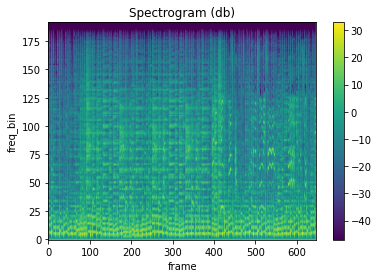

In [10]:
# Sanity test
plot_spectrogram(spectograms[3][0])

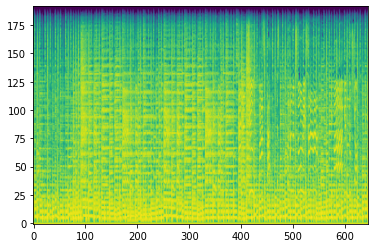

In [11]:
create_img_specs = True
log_scale_specs = True
normalize = True

trimmed_specs = trim_tensor_spectograms(spectograms)
if create_img_specs:
    if log_scale_specs:
        trimmed_specs = log_scale_spectogram(trimmed_specs)
    
    # Creating img spectograms
    img_specs = tensors_to_img(trimmed_specs)
    
    # Sanity check
    plt.imshow(img_specs[3][0], origin='lower', aspect='auto')
    
    # Normalizing img spectograms
    if normalize:
        normalized_specs = normalize_img_spectograms(img_specs)

In [12]:
if create_img_specs:
    tmp_data = genres_and_files[genres_and_files['Song_paths'] != './genre_data/Data/genres_original/jazz/jazz.00054.wav']
    print(tmp_data.shape)
    print(normalized_specs.shape)
    tmp_data['Spectogram'] = [spec for spec in normalized_specs]
    data = tmp_data[['Genre', 'Spectogram']].reset_index(drop=True)
else: 
    tmp_data = genres_and_files[genres_and_files['Song_paths'] != './genre_data/Data/genres_original/jazz/jazz.00054.wav']
    tmp_data['Spectogram'] = spectograms
    data = tmp_data[['Genre', 'Spectogram']].reset_index(drop=True)
data

(999, 2)
(999, 1, 192, 645)


/tmp/ipykernel_1119574/3339303593.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_data['Spectogram'] = [spec for spec in normalized_specs]


Genre                                         Spectogram
0    disco  [[[0.5197113, 0.274184, 0.25530207, 0.26443446...
1    disco  [[[0.36135483, 0.352109, 0.27384606, 0.3595419...
2    disco  [[[0.5159716, 0.5347395, 0.5126168, 0.42814422...
3    disco  [[[0.49743253, 0.5269189, 0.5275505, 0.5280753...
4    disco  [[[0.5448033, 0.42899615, 0.500516, 0.51697713...
..     ...                                                ...
994  blues  [[[0.4945685, 0.36737758, 0.25995976, 0.259775...
995  blues  [[[0.44503483, 0.3475778, 0.2957288, 0.3011261...
996  blues  [[[0.36844838, 0.15442336, 0.10450709, 0.11995...
997  blues  [[[0.5348207, 0.5192789, 0.5006953, 0.39305753...
998  blues  [[[0.52208877, 0.46082586, 0.4939615, 0.485806...

[999 rows x 2 columns]

In [13]:
# padding tensors to get the same dimensions
if not create_img_specs:
    max_len = max(spec.shape[-1] for spec in data['Spectogram'])

    def padder(spectogram, max_len):
        pad_len = max_len - spectogram.shape[-1]
        if pad_len > 0:
            spectogram = F.pad(spectogram, (0, pad_len))
        return spectogram

    # Apply the padder function to the 'Spectogram' column
    data['Spectogram'] = data['Spectogram'].apply(lambda spec: padder(spec, max_len))

In [14]:
le = preprocessing.LabelEncoder()
le.fit(data['Genre'].unique())
data['Genre'] = le.transform(data['Genre'])
data

Genre                                         Spectogram
0        3  [[[0.5197113, 0.274184, 0.25530207, 0.26443446...
1        3  [[[0.36135483, 0.352109, 0.27384606, 0.3595419...
2        3  [[[0.5159716, 0.5347395, 0.5126168, 0.42814422...
3        3  [[[0.49743253, 0.5269189, 0.5275505, 0.5280753...
4        3  [[[0.5448033, 0.42899615, 0.500516, 0.51697713...
..     ...                                                ...
994      0  [[[0.4945685, 0.36737758, 0.25995976, 0.259775...
995      0  [[[0.44503483, 0.3475778, 0.2957288, 0.3011261...
996      0  [[[0.36844838, 0.15442336, 0.10450709, 0.11995...
997      0  [[[0.5348207, 0.5192789, 0.5006953, 0.39305753...
998      0  [[[0.52208877, 0.46082586, 0.4939615, 0.485806...

[999 rows x 2 columns]

#### Making CNN with pytorch

In [15]:
np.random.seed(15)

train_fraction = 4/5
val_fraction = 1/6

# Step 1: Create a selection of indices for training and testing
total_size = len(data)
train_size = int(train_fraction * total_size)
test_size = total_size - train_size

# Generate random indices for training and testing
all_indices = np.arange(total_size)
np.random.shuffle(all_indices)

train_indices = all_indices[:train_size]
test_indices = all_indices[train_size:]

# Step 2: Create training and test datasets
train_data = data.iloc[train_indices].reset_index(drop=True)
test_data = data.iloc[test_indices].reset_index(drop=True)

# Step 3: Create a validation set from the training data
val_size = int(val_fraction * train_size)
train_size = train_size - val_size

# Generate random indices for training and validation
train_indices, val_indices = train_indices[:train_size], train_indices[train_size:]

# Create training and validation datasets
train_data = data.iloc[train_indices].reset_index(drop=True)
val_data = data.iloc[val_indices].reset_index(drop=True)

# Sanity check
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))
print("Val data size:", len(val_data))

# Check class distributions
train_class_counts = Counter(train_data['Genre'])
print("Class Distribution in Training Dataset:")
for label, count in train_class_counts.items():
    print(f"{label}: {count} samples")

val_class_counts = Counter(val_data['Genre'])
print("\nClass Distribution in Validation Dataset:")
for label, count in val_class_counts.items():
    print(f"{label}: {count} samples")

test_class_counts = Counter(test_data['Genre'])
print("\nClass Distribution in Test Dataset:")
for label, count in test_class_counts.items():
    print(f"{label}: {count} samples")

Train data size: 666
Test data size: 200
Val data size: 133
Class Distribution in Training Dataset:
0: 70 samples
5: 61 samples
2: 73 samples
3: 68 samples
8: 65 samples
4: 65 samples
7: 66 samples
1: 64 samples
6: 62 samples
9: 72 samples

Class Distribution in Validation Dataset:
9: 12 samples
1: 10 samples
0: 12 samples
4: 16 samples
8: 15 samples
5: 16 samples
6: 21 samples
2: 8 samples
3: 10 samples
7: 13 samples

Class Distribution in Test Dataset:
5: 22 samples
7: 21 samples
1: 26 samples
2: 19 samples
8: 20 samples
3: 22 samples
0: 18 samples
4: 19 samples
9: 16 samples
6: 17 samples


In [16]:
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        spectogram = self.dataframe.iloc[index]['Spectogram']
        label = self.dataframe.iloc[index]['Genre']
        return spectogram, label

In [17]:
def train(model, train_loader, val_loader, num_epochs=1):
    best_val_accuracy = 0.0  # Track the best validation accuracy
    best_model_state = None  # Store the state of the best model
    best_model_states = []  # Store the states of the best models
    best_val_accuracies = []  # Store the corresponding best validation accuracie

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            if i % 200 == 199:  # Print every 200 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] Train Loss: {running_loss / 200:.3f}')
                running_loss = 0.0

        # Step the scheduler to update the learning rate (once per epoch)
        scheduler.step()

        # Calculate training accuracy after the epoch
        train_accuracy = correct_train / total_train

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        correct_val = 0
        total_val = 0
        val_loss = 0.0  # Running loss for validation set

        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        # Calculate validation accuracy after the epoch
        val_accuracy = correct_val / total_val
        print(f'Epoch {epoch + 1}: '
              f'Train Loss: {running_loss / len(train_loader):.3f}, '
              f'Train Accuracy: {train_accuracy:.3f}, '
              f'Validation Accuracy: {val_accuracy:.3f}')

        if val_accuracy > min(best_val_accuracies, default=0.0):
            # Save the current model state
            best_model_states.append(model.state_dict())
            best_val_accuracies.append(val_accuracy)
            
            if val_accuracy == max(best_val_accuracies, default=0.0):
                best_model_state = model.state_dict()

            # Keep only the top 10 best models
            if len(best_model_states) > 10:
                min_index = best_val_accuracies.index(min(best_val_accuracies))
                best_model_states.pop(min_index)
                best_val_accuracies.pop(min_index)

    # Return the best model state
    return best_val_accuracies, best_model_states[::-1], best_model_state, model.state_dict()

In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Minst avansert
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 190, kernel_size=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(190, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.adpt_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 7 * 7, 128),  # adaptive average
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )
        
        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.conv_layers(x)
        out = self.adpt_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [96]:
BATCH_SIZE = 32
NUM_EPOCHS = 120
initial_lr = 0.001

# Creating data loaders
train_loader = DataLoader(PandasDataset(train_data), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(PandasDataset(val_data), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Loading model
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Setting parameters
step_size = 100
gamma = 0.1
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma) # LR scheduler

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=initial_lr)

best_val_accuracies, best_model_states, best_model_state, last_state = train(model, train_loader, val_loader, num_epochs=NUM_EPOCHS)

Epoch 1: Train Loss: 2.315, Train Accuracy: 0.111, Validation Accuracy: 0.135
Epoch 2: Train Loss: 2.178, Train Accuracy: 0.191, Validation Accuracy: 0.195
Epoch 3: Train Loss: 2.078, Train Accuracy: 0.227, Validation Accuracy: 0.203
Epoch 4: Train Loss: 2.014, Train Accuracy: 0.234, Validation Accuracy: 0.203
Epoch 5: Train Loss: 1.944, Train Accuracy: 0.269, Validation Accuracy: 0.195
Epoch 6: Train Loss: 1.884, Train Accuracy: 0.288, Validation Accuracy: 0.278
Epoch 7: Train Loss: 1.864, Train Accuracy: 0.293, Validation Accuracy: 0.353
Epoch 8: Train Loss: 1.788, Train Accuracy: 0.297, Validation Accuracy: 0.444
Epoch 9: Train Loss: 1.707, Train Accuracy: 0.357, Validation Accuracy: 0.421
Epoch 10: Train Loss: 1.667, Train Accuracy: 0.368, Validation Accuracy: 0.391
Epoch 11: Train Loss: 1.636, Train Accuracy: 0.380, Validation Accuracy: 0.414
Epoch 12: Train Loss: 1.510, Train Accuracy: 0.422, Validation Accuracy: 0.436
Epoch 13: Train Loss: 1.496, Train Accuracy: 0.425, Validatio

#### Evaluating the model

In [69]:
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predictions
            _, predictions = torch.max(outputs, 1)

            # Collect labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    return all_labels, all_predictions

def max_vote_evaluate_model(model_states, dataloader):
    # Set each model to evaluation mode
    models = []
    count = 0
    for model_state in model_states:
        count += 1
        print(count)
        model = CNN().to(device)
        model.load_state_dict(model_state)
        model.eval()
        models.append(model)

    all_predictions = []  # Store predictions from all models
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            model_predictions = []

            # Obtain predictions from each model
            for model in models:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                model_predictions.append(predicted.cpu().numpy())
            
            # Perform max-vote
            stacked_predictions = np.vstack(model_predictions)
            ensemble_predictions, _ = mode(stacked_predictions, axis=0, keepdims=True)
            ensemble_predictions = ensemble_predictions.flatten()

            # Store predictions from the ensemble
            all_predictions.extend(ensemble_predictions.tolist())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_predictions

In [97]:
multiple_models = False

test_dataset = PandasDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Load best model state
best_model = CNN().to(device)
best_model.load_state_dict(best_model_state)

# Evaluate the model on the test set
if multiple_models: 
    true_labels, predicted_labels = max_vote_evaluate_model(best_model_states, test_loader)
else:
    true_labels, predicted_labels = evaluate_model(best_model, test_loader)

predicted_labels = le.inverse_transform(predicted_labels)
true_labels = le.inverse_transform(true_labels)

# Print the classification report
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

       blues       0.70      0.78      0.74        18
   classical       0.86      0.96      0.91        26
     country       0.69      0.47      0.56        19
       disco       0.80      0.55      0.65        22
      hiphop       0.64      0.84      0.73        19
        jazz       0.80      0.73      0.76        22
       metal       0.84      0.94      0.89        17
         pop       0.86      0.86      0.86        21
      reggae       0.69      0.55      0.61        20
        rock       0.45      0.62      0.53        16

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.72       200
weighted avg       0.74      0.73      0.73       200



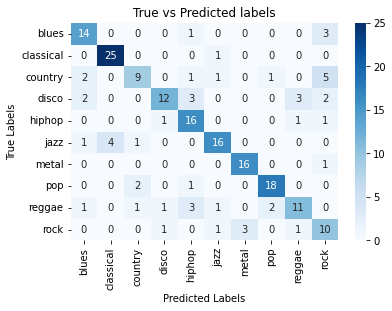

In [98]:
# Assuming y_true and y_pred are your true and predicted labels
cm = confusion_matrix(true_labels, predicted_labels)
class_labels = le.classes_

# Using seaborn to create a heatmap for better visualization
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("True vs Predicted labels")
plt.show()

#### Saving and loading models

In [76]:
def save_model(model, title=''):
    torch.save(model, './models/' + title + '_model.pth')
    torch.save(model.state_dict(), './models/' + title + '_model_state.pth')

def load_model(path_model, path_state):
    # Load model
    loaded_model = torch.load(path_model)

    # Load the model state
    loaded_model.load_state_dict(torch.load(path_state))
    loaded_model = loaded_model.to(device)
    return loaded_model

title = 'good3'

save_model(best_model, title=title)

model_path = './models/'

loaded = load_model(model_path + title + '_model.pth', model_path + title + '_model_state.pth')